<a href="https://colab.research.google.com/github/TaigoKuriyama/national_park_prediction/blob/master/notebook/model_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# show upload dialog
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()
uploaded = files.upload()
import pandas as pd
from sklearn.cross_validation import train_test_split
import math
import numpy as np

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
# tsv to Dataframe
df_train = pd.read_csv('train.tsv',sep='\t')
df_test = pd.read_csv('test.tsv',sep='\t')

In [3]:
# Feature engineering from datetime
def create_date_future(df):
    df['datetime'] = pd.to_datetime(df['datetime']) # dtypeをdatetime64に変換
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek

create_date_future(df_train)
create_date_future(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3
2,2015-01-01,日光国立公園,29714,2015,1,1,3
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3


In [4]:
# label encoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

def onehot_encdr_park(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['park'])
    le.transform(['阿寒摩周国立公園', '十和田八幡平国立公園', '日光国立公園', '伊勢志摩国立公園','大山隠岐国立公園','阿蘇くじゅう国立公園', '霧島錦江湾国立公園', '慶良間諸島国立公園']) 
    
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['park'])
    df_park = pd.DataFrame(park_onehot,columns=le.classes_)
    df = pd.concat([df,df_park],axis=1)
    return df

df_train = onehot_encdr_park(df_train)
df_test = onehot_encdr_park(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,0,0,1,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,0,0,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,0,0,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,0,0,0,0,0


In [5]:
def onehot_encdr_dayofweek(df):
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['dayofweek'])
    df_park = pd.DataFrame(park_onehot,columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    df = pd.concat([df,df_park],axis=1)
    return df

df_train = onehot_encdr_dayofweek(df_train)
df_test = onehot_encdr_dayofweek(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [0]:
# holiday data include Saturday, Sunday
df_holiday = pd.read_csv('holiday.csv')
df_holiday['datetime'] = pd.to_datetime(df_holiday['datetime'])

In [7]:
# holiday data exclude Saturday, Sunday
df_holiday_exc_wkend = pd.read_csv('holiday.csv')
df_holiday_exc_wkend['datetime'] = pd.to_datetime(df_holiday_exc_wkend['datetime'])
df_holiday_exc_wkend['dayofweek'] = df_holiday_exc_wkend['datetime'].dt.dayofweek

# dayofweekが5 or 6(土曜or日曜)の場合、holidayカラムの値を0にする
df_holiday_exc_wkend.loc[(df_holiday_exc_wkend['dayofweek'] == 5) | (df_holiday_exc_wkend['dayofweek'] == 6), 'holiday'] = 0
df_holiday_exc_wkend = df_holiday_exc_wkend[['datetime','holiday']]
df_holiday_exc_wkend = df_holiday_exc_wkend.rename(columns={'holiday': 'pub_holiday'})
df_holiday_exc_wkend.head()

,datetime,pub_holiday
0,2015-01-01,1
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0


In [0]:
# sin cos curve
N = 365 # データ数
N_ = 366
n = np.arange(365)
n_ = np.arange(366)

#  Not leap year
sin_cur_not_leap= np.sin(2*np.pi*n/N)
cos_cur_not_leap= np.cos(2*np.pi*n/N)

#  leap year
sin_cur_leap= np.sin(2*np.pi*n_/N_)
cos_cur_leap= np.cos(2*np.pi*n_/N_)

# concat for 2015, 2016
sin_cur = np.concatenate((sin_cur_not_leap, sin_cur_leap), axis=0)
cos_cur = np.concatenate((cos_cur_not_leap, cos_cur_leap), axis=0)

# to dataframe
sin_columns = 'sin'
df_sin_cur_train = pd.DataFrame(data=sin_cur,dtype='float')
df_cos_cur_train = pd.DataFrame(data=cos_cur,dtype='float')

# concat for 2017
df_sin_cur_test = pd.DataFrame(data=sin_cur_not_leap,dtype='float')
df_cos_cur_test = pd.DataFrame(data=cos_cur_not_leap,dtype='float')

In [9]:
# taget encoding
#　df_train_mean = df_train.groupby('datetime',as_index=False).mean()
df_visitors_mean = df_train.groupby('park',as_index=False).mean()[['park','visitors']]
df_visitors_mean

,park,visitors
0,伊勢志摩国立公園,16314.704514
1,十和田八幡平国立公園,8890.787962
2,大山隠岐国立公園,716.424077
3,慶良間諸島国立公園,137.994528
4,日光国立公園,11324.525308
5,阿寒摩周国立公園,4422.611491
6,阿蘇くじゅう国立公園,270.445964
7,霧島錦江湾国立公園,15416.395349


In [10]:
# 学習データと休日データの結合
df_merged = pd.merge(df_train,df_holiday_exc_wkend,on='datetime')
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [11]:
# 学習データとsin/cosカーブデータの結合
df_datetime_train = df_train[~df_train.duplicated(subset='datetime')]['datetime']
df_datetime_train = df_datetime_train.reset_index()
df_datetime_train = df_datetime_train['datetime']
df_sin_cos = pd.concat([df_datetime_train,df_sin_cur_train,df_cos_cur_train], axis=1)
df_sin_cos.columns = ['datetime', 'sin', 'cos']
df_merged = pd.merge(df_merged,df_sin_cos,on='datetime')
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,1,0,0,0,1,0.0,1.0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,1,0,0,0,1,0.0,1.0


In [12]:
df_merged = pd.merge(df_merged,df_visitors_mean,on='park')
df_merged.head()

,datetime,park,visitors_x,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,visitors_y
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,1,0,0,0,1,0.000000,1.000000,4422.611491
1,2015-01-02,阿寒摩周国立公園,11153,2015,1,2,4,0,0,0,...,0,0,0,1,0,0,0,0.017213,0.999852,4422.611491
2,2015-01-03,阿寒摩周国立公園,12343,2015,1,3,5,0,0,0,...,0,0,0,0,1,0,0,0.034422,0.999407,4422.611491
3,2015-01-04,阿寒摩周国立公園,6732,2015,1,4,6,0,0,0,...,0,0,0,0,0,1,0,0.051620,0.998667,4422.611491
4,2015-01-05,阿寒摩周国立公園,4877,2015,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0.068802,0.997630,4422.611491


In [13]:
# drop columns which is not needed
df_except_y = df_merged.drop(['park','visitors_x','datetime'], axis=1)
X = df_except_y.as_matrix() 
y = df_merged['visitors_x'].as_matrix()
df_except_y.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,visitors_y
0,2015,1,1,3,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0.000000,1.000000,4422.611491
1,2015,1,2,4,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0.017213,0.999852,4422.611491
2,2015,1,3,5,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0.034422,0.999407,4422.611491
3,2015,1,4,6,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0.051620,0.998667,4422.611491
4,2015,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.068802,0.997630,4422.611491


In [14]:
# holidayデータとのマージ
df_test_merged = pd.merge(df_test,df_holiday_exc_wkend,on='datetime')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [0]:
# sin/cosカーブデータとのマージ
df_datetime_test = df_test[~df_test.duplicated(subset='datetime')]['datetime']
df_datetime_test = df_datetime_test.reset_index()
df_datetime_test = df_datetime_test['datetime']
df_sin_cos_test = pd.concat([df_datetime_test,df_sin_cur_test,df_cos_cur_test], axis=1)
df_sin_cos_test.columns = ['datetime', 'sin', 'cos']
df_test_merged = pd.merge(df_test_merged,df_sin_cos_test,on='datetime')

In [16]:
# target encodingとのマージ
df_test_merged = pd.merge(df_test_merged,df_visitors_mean,on='park')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,visitors
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,1,0,0.000000,1.000000,4422.611491
1,8,2017-01-02,阿寒摩周国立公園,2017,1,2,0,0,0,0,...,0,0,0,0,0,0,1,0.017213,0.999852,4422.611491
2,16,2017-01-03,阿寒摩周国立公園,2017,1,3,1,0,0,0,...,1,0,0,0,0,0,0,0.034422,0.999407,4422.611491
3,24,2017-01-04,阿寒摩周国立公園,2017,1,4,2,0,0,0,...,0,1,0,0,0,0,0,0.051620,0.998667,4422.611491
4,32,2017-01-05,阿寒摩周国立公園,2017,1,5,3,0,0,0,...,0,0,1,0,0,0,0,0.068802,0.997630,4422.611491


In [17]:
# drop columns which is not needed
df_test_merged = df_test_merged.drop(['park','datetime','index'], axis=1)
df_test_merged = df_test_merged.fillna(0)
X_test = df_test_merged.as_matrix()
df_test_merged.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,visitors
0,2017,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0.000000,1.000000,4422.611491
1,2017,1,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.017213,0.999852,4422.611491
2,2017,1,3,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0.034422,0.999407,4422.611491
3,2017,1,4,2,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0.051620,0.998667,4422.611491
4,2017,1,5,3,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0.068802,0.997630,4422.611491


In [0]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

In [28]:
# split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# training
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# predict
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print('MAE train：{0}'.format(mean_absolute_error(y_train, y_train_pred)))
print('MAE test：{0}'.format(mean_absolute_error(y_test, y_test_pred)))

MAE train：1040.643827698861
MAE test：1424.5463703780733


In [30]:
y_train_pred

array([  177.78013372,  6907.1371589 , 10406.87978856, ...,
       12956.66890363,  5701.23326826,  2676.27259073])

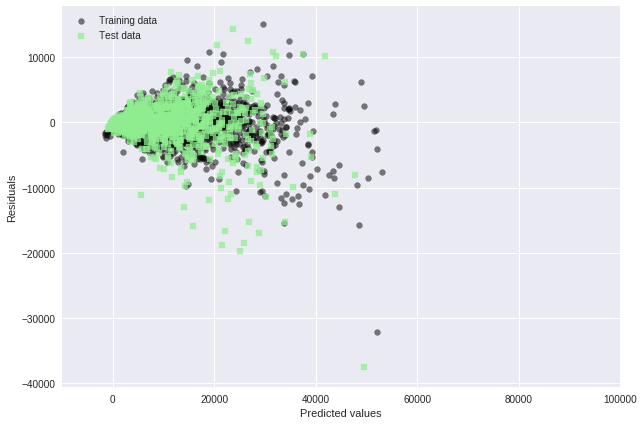

In [32]:
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-10000, 100000])
plt.show()

In [33]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

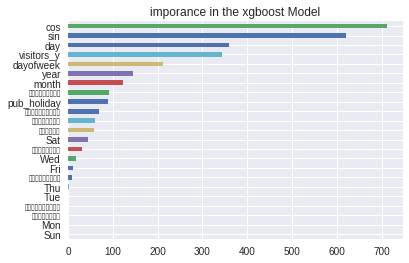

In [34]:
# future importance
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(model.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [0]:
# predict
y_pred = model.predict(X)

In [0]:
# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit =df_submit.where(df_submit.iloc[:, [0]] > 0, 0)

In [0]:
df_submit.to_csv('submit_13.tsv',sep='\t',header=None)
files.download('submit_13.tsv')